In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import matplotlib.pyplot as plt
import numpy as np
import sys, os, os.path
import subprocess
import shutil
import time
import signal
import argparse
import random
import torch
import torch.backends.cudnn as cudnn

from model import Model
import offline

import tools
import data

/esat/opal/kkelchte/docker_home/tensorflow/pytorch_pilot/pilot/tools.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib64/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/users/visics/kkelchte/tensorflow_1.8/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/users/visics/kkelchte/tensorflow_1.8/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/users/visics/kkelchte/tensorflow_1.8/lib/python2.7/site-packages/ipykernel/kernela

In [3]:
parser = argparse.ArgumentParser(description='Main pilot that can train or evaluate online or offline from a dataset.')
  
# ==========================
#   Training Parameters
# ==========================
parser.add_argument("--testing", action='store_true', help="In case we're only testing, the model is tested on the test.txt files and not trained.")
parser.add_argument("--learning_rate", default=0.1, type=float, help="Start learning rate.")
parser.add_argument("--batch_size",default=64,type=int,help="Define the size of minibatches.")
parser.add_argument("--clip",default=10**4,type=float,help="Clip gradients to avoid 'nan' loss values.")
parser.add_argument("--max_episodes",default=1000,type=int,help="The maximum number of episodes (~runs through all the training data.)")
parser.add_argument("--tensorboard", action='store_true', help="Save logging in tensorboard.")
parser.add_argument("--create_scratch_checkpoint", action='store_true', help="Dont train, just save checkpoint before starting and quit.")

# ==========================
#   Lifelonglearning Parameters
# ==========================
parser.add_argument("--lifelonglearning",action='store_true',help="In case there is a previous domain upon which the model was trained, use the lifelonglearning regularization to overcome forgetting.")
parser.add_argument("--update_importance_weights",action='store_true',help="Update importance weights for all variables for this domain.")
parser.add_argument("--lll_weight", default=1, type=float, help="Weight the lifelonglearning regularization term in the overall loss.")
parser.add_argument("--calculate_importance_weights",action='store_true',help="Calculate the importance weights at the end of training and save them as pickled object.")



# ==========================
#   Offline Parameters
# ==========================
parser.add_argument("--visualize_saliency_of_output",action='store_true',help="Visualize saliency maps of the output.")
parser.add_argument("--visualize_deep_dream_of_output",action='store_true',help="Visualize gradient ascent maps for different extreme controls.")
parser.add_argument("--visualize_activations",action='store_true',help="Visualize activation.")
parser.add_argument("--visualize_control_activation_maps",action='store_true',help="Visualize control activation map.")
parser.add_argument("--histogram_of_activations",action='store_true',help="Summarize all activations in a histogram.")
parser.add_argument("--histogram_of_weights",action='store_true',help="Summarize all weights in a histogram.")

# ===========================
#   Utility Parameters
# ===========================
# Print output of ros verbose or not
parser.add_argument("--load_config", action='store_true',help="Load flags from the configuration file found in the checkpoint path.")
parser.add_argument("--verbose", action='store_false', help="Print output of ros verbose or not.")
parser.add_argument("--summary_dir", default='tensorflow/log/', type=str, help="Choose the directory to which tensorflow should save the summaries.")
parser.add_argument("-t","--log_tag", default='testing', type=str, help="Add log_tag to overcome overwriting of other log files.")
parser.add_argument("--device", default='gpu', type=str, help= "Choose to run on gpu or cpu: /cpu:0 or /gpu:0")
parser.add_argument("--random_seed", default=123, type=int, help="Set the random seed to get similar examples.")
parser.add_argument("--owr", action='store_true', help="Overwrite existing logfolder when it is not testing.")
parser.add_argument("--action_bound", default=1.0, type=float, help= "Define between what bounds the actions can go. Default: [-1:1].")
parser.add_argument("--action_dim", default=1.0, type=float, help= "Define the dimension of the actions: 1dimensional as it only turns in yaw.")
parser.add_argument("--real", action='store_true', help="Define settings in case of interacting with the real (bebop) drone.")
parser.add_argument("--evaluate", action='store_true', help="Just evaluate the network without training.")
parser.add_argument("--random_learning_rate", action='store_true', help="Use sampled learning rate from UL(10**-2, 1)")
parser.add_argument("--plot_depth", action='store_true', help="Specify whether the depth predictions is saved as images.")

# ===========================
#   Data Parameters
# ===========================
# parser.add_argument("--hdf5", action='store_true', help="Define wether dataset is hdf5 type.")
parser.add_argument("--load_data_in_ram", action='store_true', help="Define wether the dataset is preloaded into RAM.")
parser.add_argument("--dataset", default="esatv3_expert_500", type=str, help="pick the dataset in data_root from which your movies can be found.")
parser.add_argument("--data_root", default="pilot_data/",type=str, help="Define the root folder of the different datasets.")
parser.add_argument("--num_threads", default=4, type=int, help="The number of threads for loading one minibatch.")
parser.add_argument("--control_file", default='control_info.txt', type=str, help="Define the name of the file with the action labels.")
parser.add_argument("--depth_directory", default='Depth', type=str, help="Define the name of the directory containing the depth images: Depth or Depth_predicted.")
parser.add_argument("--subsample", default=1, type=int, help="Subsample data over time: e.g. subsample 2 to get from 20fps to 10fps.")
parser.add_argument("--normalized_output", action='store_true', help="Try to fill a batch with different actions [-1, 0, 1].")
parser.add_argument("--shifted_input", action='store_true', help="Shift data from range 0,1 to -0.5,0.5")
parser.add_argument("--scaled_input", action='store_true', help="Scale the input to 0 mean and 1 std.")
parser.add_argument('--scale_means', default=[0.42, 0.46, 0.5],nargs='+', help="Means used for scaling the input around 0")
parser.add_argument('--scale_stds', default=[0.218, 0.239, 0.2575],nargs='+', help="Stds used for scaling the input around 0")
parser.add_argument("--time_length", default=10, type=int, help="In case of LSTM network, how long in time is network unrolled for training.")
parser.add_argument("--sliding_tbptt", action='store_true', help="In case of LSTM network, slide over batches of data rather than sample randomly.")
parser.add_argument("--sliding_step_size", default=1, type=int, help="In case of LSTM network and sliding_tbptt, define the time steps between two consecutive training batches.")


# ===========================
#   Model Parameters
# ===========================
parser.add_argument("--depth_multiplier",default=0.25,type=float, help= "Define the depth of the network in case of mobilenet.")
parser.add_argument("--network",default='tiny_net',type=str, help="Define the type of network: mobile, mobile_nfc, alex, squeeze, ...")
# parser.add_argument("--output_size",default=[55,74],type=int, nargs=2, help="Define the output size of the depth frame: 55x74 [drone], 1x26 [turtle], only used in case of depth_q_net.")
parser.add_argument("--pretrained", action='store_true',help="Specify whether the network should be loaded with imagenet pretrained features.")
# parser.add_argument("--n_fc", action='store_true',help="In case of True, prelogit features are concatenated before feeding to the fully connected layers.")
parser.add_argument("--n_frames",default=5,type=int,help="Specify the amount of frames concatenated in case of n_fc like mobile_nfc.")
parser.add_argument("--auxiliary_depth", action='store_true',help="Specify whether a depth map is predicted.")
parser.add_argument("--discrete", action='store_true',help="Specify whether the output action space is discrete.")
parser.add_argument("--action_quantity",default=3, type=int, help="Define the number of actions in the output layer.")

# INITIALIZATION
parser.add_argument("--checkpoint_path",default='', type=str, help="Specify the directory of the checkpoint of the earlier trained model.")
parser.add_argument("--continue_training",action='store_true', help="Continue training of the prediction layers. If false, initialize the prediction layers randomly.")
# parser.add_argument("--scratch", action='store_true', help="Initialize full network randomly.")

# TRAINING

parser.add_argument("--il_weight", default=1.0, type=float, help="Define the weight of the Imitation Learning Loss in comparison to the Reinforcement Learning Loss.")
parser.add_argument("--depth_weight", default=1.0, type=float, help="Define the weight applied to the depth values in the loss relative to the control loss.")
parser.add_argument("--control_weight", default=1.0, type=float, help="Define the weight applied to the control loss.")
parser.add_argument("--weight_decay",default=0.00004,type=float, help= "Weight decay of inception network")
parser.add_argument("--init_scale", default=0.0005, type=float, help= "Std of uniform initialization")
parser.add_argument("--grad_mul_weight", default=0.001, type=float, help="Specify the amount the gradients of prediction layers.")
parser.add_argument("--dropout", default=0.5, type=float, help="Specify the probability of dropout to keep the activation.")
# parser.add_argument("--hidden_size", default=100, type=float, help="Specify the probability of dropout to keep the activation.")

parser.add_argument("--min_depth", default=0.0, type=float, help="clip depth loss with weigths to focus on correct depth range.")
parser.add_argument("--max_depth", default=5.0, type=float, help="clip depth loss with weigths to focus on correct depth range.")
parser.add_argument("--optimizer", default='SGD', type=str, help="Specify optimizer, options: Adadelta, SGD")
parser.add_argument("--no_batchnorm_learning",action='store_false', help="In case of no batchnorm learning, are the batch normalization params (alphas and betas) not further adjusted.")
parser.add_argument("--initializer",default='xavier',type=str, help="Define the initializer: xavier or uniform [-init_scale, init_scale]")

parser.add_argument("--loss",default='MSE',type=str, help="Define the loss: MSE, CrossEntropy")

# parser.add_argument("--max_loss", default=100, type=float, help= "Define the maximum loss before it is clipped.")
# parser.add_argument("--clip_loss_to_max",action='store_true', help="Over time, allow only smaller losses by clipping the maximum allowed loss to the lowest maximum loss.")

# ===========================
#   Replay Parameters
# ===========================

parser.add_argument("--replay_priority", default='no', type=str, help="Define which type of weights should be used when sampling from replay buffer: no, uniform_action, uniform_collision, td_error, state/action/target_variance, random_action")
parser.add_argument("--prioritized_keeping", action='store_true', help="In case of True, the replay buffer only keeps replay data that is most likely to be sampled.")
parser.add_argument("--hard_replay_buffer", action='store_true', help="Add a replaybuffer with the hardest examples (according to the loss).")
parser.add_argument("--hard_batch_size", default=100, type=int, help="Define the amount of data in one batch coming from a hard replay buffer.")

# ===========================
#   Rosinterface Parameters
# ===========================
parser.add_argument("--online", action='store_true', help="Training/evaluating online in simulation.")
parser.add_argument("--buffer_size", default=1000, type=int, help="Define the number of experiences saved in the buffer.")
parser.add_argument("--ou_theta", default=0.05, type=float, help= "Theta is the pull back force of the OU Noise.")
parser.add_argument("--noise", default='ou', type=str, help="Define whether the noise is temporally correlated (ou) or uniformly distributed (uni).")
parser.add_argument("--sigma_z", default=0.0, type=float, help= "sigma_z is the amount of noise in the z direction.")
parser.add_argument("--sigma_x", default=0.0, type=float, help= "sigma_x is the amount of noise in the forward speed.")
parser.add_argument("--sigma_y", default=0.0, type=float, help= "sigma_y is the amount of noise in the y direction.")
parser.add_argument("--sigma_yaw", default=0.0, type=float, help= "sigma_yaw is the amount of noise added to the steering angle.")
parser.add_argument("--speed", default=1.3, type=float, help= "Define the forward speed of the quadrotor.")
parser.add_argument("--turn_speed", default=0.5, type=float, help= "Define the forward speed while turning.")
parser.add_argument("--alpha",default=0., type=float, help="Policy mixing: choose with a binomial probability of alpha for the experts policy instead of the DNN policy..")
parser.add_argument("--epsilon",default=0, type=float, help="Apply epsilon-greedy policy for exploration.")
parser.add_argument("--epsilon_decay", default=0.0, type=float, help="Decay the epsilon exploration over time with a slow decay rate of 1/10.")
parser.add_argument("--prefill", action='store_true', help="Fill the replay buffer first with random (epsilon 1) flying behavior before training.")
parser.add_argument("--gradient_steps", default=1, type=int, help="Define the number of batches or gradient steps are taken between 2 runs.")
# parser.add_argument("--empty_buffer", action='store_true', help="Empty buffer after each rollout.")
parser.add_argument("--buffer_update_rule", default='nothing',type=str, help="nothing: FIFO buffer. empty: empty buffer after each training step. TODO: hard: drop certain partition of recent frames and keep only hardest.")
parser.add_argument("--buffer_hard_ratio", default=1,type=float, help="if buffer_update_rule == hard, arange this ratio of the buffer's samples according to how hard they are and drop the rest, to be filled with recent frames.")

parser.add_argument("--max_batch_size", default=-1, type=int, help="Define the max size of the batch (only if batch_size is -1).")
parser.add_argument("--recovery_compensation", default=1, type=float, help="Define amount the neural network should compensate for the to-be-recovered movement.")

# parser.add_argument("--dont_show_depth",action='store_true', help="Publish the predicted horizontal depth array to topic ./depth_prection so show_depth can visualize this in another node.")

parser.add_argument("--field_of_view", default=104, type=int, help="The field of view of the camera cuts the depth scan in the range visible for the camera. Value should be even. Normal: 72 (-36:36), Wide-Angle: 120 (-60:60)")
parser.add_argument("--smooth_scan", default=4, type=int, help="The 360degrees scan has a lot of noise and is therefore smoothed out over 4 neighboring scan readings")

parser.add_argument("--pause_simulator", action='store_true', help="Pause simulator during frame processing, making discrete steps.")
parser.add_argument("--export_buffer", action='store_true', help="Save the replaybuffer as dataset after each run.")
parser.add_argument("--no_training", action='store_true', help="avoid saving to the replay buffer and taking gradient steps.")

parser.add_argument("--horizon", default=0, type=int, help="Define the number steps back before collision, the collision label is applied to. ")
parser.add_argument("--save_every_num_epochs", default=1000, type=int, help="Define after how many epochs a model should be saved while training online.")

print("[main.py] Found {0} cuda devices available.".format(torch.cuda.device_count()))

try:
    FLAGS, others = parser.parse_known_args()
except:
  pass

[main.py] Found 1 cuda devices available.


In [21]:
# Settings: Adjust FLAGS namespace for any specific network
FLAGS.discrete=True
FLAGS.network='alex_net'
FLAGS.checkpoint_path='/esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_20K/01/seed_0'
FLAGS.continue_training=True
FLAGS.loss='CrossEntropy'

In [22]:
model=Model(FLAGS)

[model.py]: Divided 3 discrete actions over [-1.0, 0.0, 1.0] with boundaries [-0.5, 0.5].
[model] Total number of trainable parameters: 57016131
[model]: loaded model from /esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_20K/01/seed_0 at epoch: 10000
[model]: loaded optimizer parameters from /esat/opal/kkelchte/docker_home/tensorflow/log/alex_net/esatv3_expert_20K/01/seed_0


In [24]:
data.prepare_data(FLAGS, model.input_size)

[data] 00000_esatv3_500
[data] 00003_esatv3
[data] 00001_esatv3


In [25]:
importance_weights=tools.calculate_importance_weights(model, data.get_all_inputs('train'), level='neuron')

[tools] calculate_importance_weights duration 127.288982153


In [40]:
print(len(importance_weights))

16


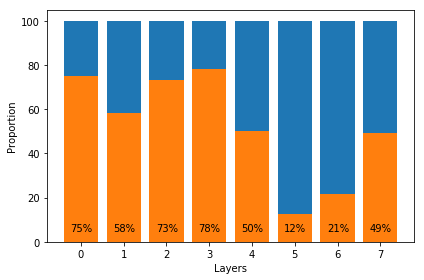

In [66]:
# plot for each layer the percentage of zero weights ~ 'free space'
freespace=[]
occupied=[]
for index, iw in enumerate(importance_weights):
    # ignore the biases
    if len(iw.shape)==1: continue
    iw=iw.flatten()
    assert(len(iw[iw==0])+len(iw[iw!=0])==len(iw))
    freespace.append(float(len(iw[iw==0]))/len(iw))
    occupied.append(float(len(iw[iw!=0]))/len(iw))

    
plt.bar(range(len(occupied)),100)
plt.bar(range(len(occupied)),[o*100 for o in occupied])
for i,v in enumerate(occupied):
    plt.text(i-0.25, 5, "{0:d}%".format(int(v*100)))

plt.xlabel('Layers')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

num_layers: 8


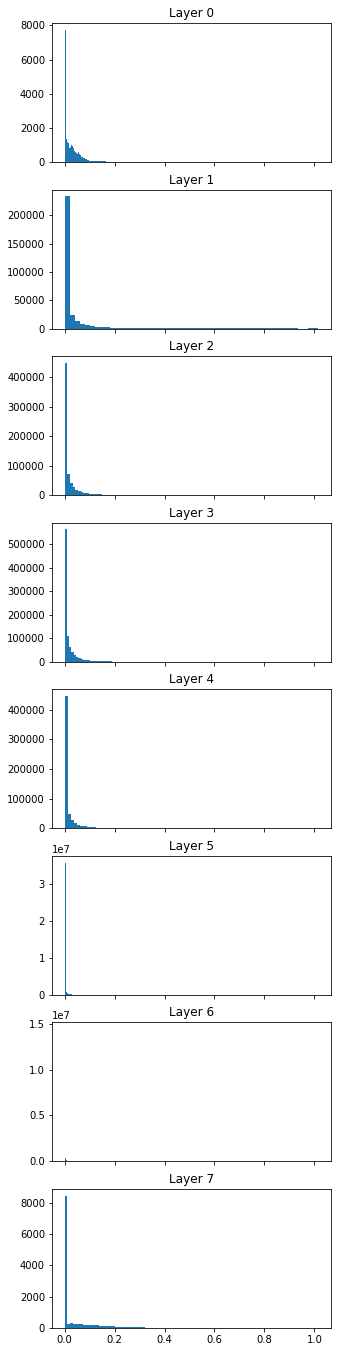

In [54]:
# histogram for each layer
num_layers=sum([1 for iw in importance_weights if len(iw.shape) > 1])
print 'num_layers:',num_layers
f, axes = plt.subplots(num_layers, 1, figsize=(5,3*num_layers), sharex=True)
index=0
for iw in importance_weights:
    if len(iw.shape)==1: continue
    axes[index].set_title('Layer {0}'.format(index))
    axes[index].hist(iw.flatten(), bins=50)
    index+=1
plt.show()